<a href="https://colab.research.google.com/github/phytometrics/plant_phenotyping_python/blob/main/notebooks/chronoroot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ChronoRoot　（未完）
訓練済みのモデルで根の解析を行うノートブック

## ライセンス
- ChronoRoot論文, Gaggion et al., 2021, GigaScience (https://academic.oup.com/gigascience/article/10/7/giab052/6324285)
    - CC-BY
- 公式レポジトリ (https://github.com/ngaggion/ChronoRoot)
    - GPLv3
- データセット (http://gigadb.org/dataset/100911)
    - GIGAdbの利用規約が定めるライセンス（http://gigadb.org/site/term; CC0相当）に準拠
- 本稿プログラムコード
    - **本章のコードは公式レポジトリのライセンスを継承してGPLv3となります。**

### メモ
python segmentFast.py imagePath --output_dir optionalSegPath --use_crf boolean --model ResUNetDS
- > 結果をchronorootで解析


## 環境構築

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp /content/drive/MyDrive/phenotyping_temp_assets/Test_ChronoRoot.zip ./
!unzip Test_ChronoRoot.zip  > /dev/null 2>&1

In [3]:
!cp /content/drive/MyDrive/phenotyping_temp_assets/cr_resunetds.onnx ./

In [4]:
# 公式レポジトリのクローニング
!git clone https://github.com/ngaggion/ChronoRoot.git

# pydensecrfのインストール
!pip install git+https://github.com/lucasb-eyer/pydensecrf.git  > /dev/null 2>&1
!pip install onnx onnxruntime-gpu > /dev/null 2>&1
# モデルチェックポイントファイルのダウンロード
# !gdown 1OSqvRXKay-0bsmQqtlmYnu_sp6-_I-eC
# !unzip modelWeights.zip

# テストデータセットのダウンロード
# !wget -O Test_ChronoRoot.zip https://ftp.cngb.org/pub/gigadb/pub/10.5524/100001_101000/100911/LabeledDataset/Test_ChronoRoot.zip
# !unzip Test_ChronoRoot.zip

# 不要ファイルの削除
# !rm modelWeights.zip
# !rm Test_ChronoRoot.zip

In [27]:
#https://colab.research.google.com/github/count0/colab-gt/blob/master/colab-gt.ipynb#scrollTo=kDn_lVxg3Z2G
!echo "deb http://downloads.skewed.de/apt jammy main" >> /etc/apt/sources.list
!apt-key adv --keyserver keyserver.ubuntu.com --recv-key 612DEFB798507F25
!apt-get update
!apt-get install python3-graph-tool python3-matplotlib python3-cairo
!apt purge python3-cairo
!apt install libcairo2-dev pkg-config python3-dev
!pip install --force-reinstall pycairo
!pip install zstandard

Executing: /tmp/apt-key-gpghome.b4t42ddO3z/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-key 612DEFB798507F25
gpg: key 612DEFB798507F25: public key "Tiago de Paula Peixoto <tiago@skewed.de>" imported
gpg: Total number processed: 1
gpg:               imported: 1
Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [555 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:7 http://downloads.skewed.de/apt jammy InRelease [7,536 B]
Get:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [1,330 kB]
Hit:10 https://ppa.l

In [29]:
!apt-get install libzbar0 &>/dev/null
!pip install pyzbar &>/dev/null

5
(2464, 3280, 3)
(2464, 3280, 3)
(2464, 3280, 3)
(2464, 3280, 3)
(2464, 3280, 3)


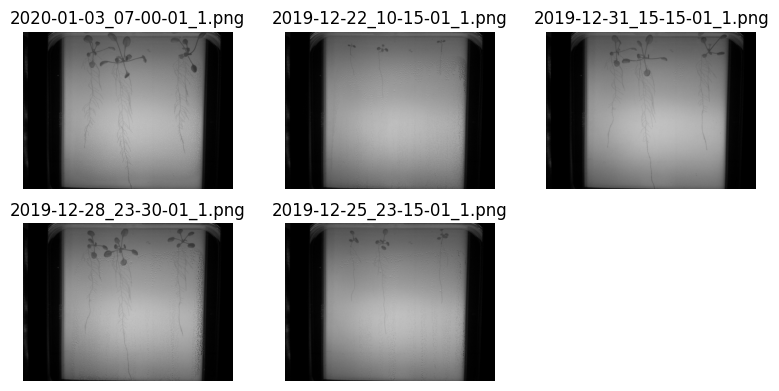

In [5]:
import os
import cv2
import matplotlib.pyplot as plt

TEST_DIR = "/content/Test_ChronoRoot/rpi14_2019-12-09_16-13/1"

# nii.gzはアノテーションファイルであるため、png拡張子の画像のみフィルタリングする
files = [x for x in os.listdir(TEST_DIR) if x.endswith(".png")]
print(len(files))  # 5枚

plt.figure(figsize=(8,4))
for i, file in enumerate(files):
    path = os.path.join(TEST_DIR, file)
    image = cv2.imread(path)
    print(image.shape)
    image = cv2.resize(image, dsize=None, fx=0.25, fy=0.25)
    plt.subplot(2,3,i+1)
    plt.title(file)
    plt.imshow(image)
    plt.axis("off")

plt.tight_layout()

In [6]:
# 作者らの公式レポジトリのREADMEに従い、colaboratoryでsegmentFastやsegmentEnsembleを実行すると
# tensorflowのバージョン齟齬によりエラーがおきます。独自の環境で実行したい方は公式推奨のdockerイメージを利用してください。

In [7]:
import onnxruntime as ort

In [8]:
# 気孔開閉判定モデルの読み込み
classifier_path = "/content/cr_resunetds.onnx"
providers = ['CUDAExecutionProvider', 'CPUExecutionProvider']
ort_session = ort.InferenceSession(classifier_path, providers=providers)

# inputとoutputの名前を把握します。
input_names = [input.name for input in ort_session.get_inputs()]
output_names = [output.name for output in ort_session.get_outputs()]

print("Input names:", input_names)
print("Output names:", output_names)

Input names: ['x:0']
Output names: ['pixel_wise_softmax/truediv:0']


In [9]:
import pydensecrf.densecrf as dcrf

def post_process(prediction):
    accum = np.zeros(prediction.shape[1:3])
    image = cv2.cvtColor((prediction[0,:,:,0]*255).astype('uint8'), cv2.COLOR_GRAY2RGB)
    image = np.ascontiguousarray(image)

    label_1 = np.transpose(prediction[0,:,:,:], (2,0,1))
    unary = -np.log(np.clip(label_1,1e-5,1.0))
    c, h, w = unary.shape
    unary = unary.transpose(0, 2, 1)
    unary = unary.reshape(2, -1)
    unary = np.ascontiguousarray(unary)

    denseCRF = dcrf.DenseCRF2D(w, h, 2)
    denseCRF.setUnaryEnergy(unary)
    denseCRF.addPairwiseBilateral(sxy=5, srgb=3, rgbim=image, compat=1)

    q = denseCRF.inference(1)
    crf_map = np.array(q).reshape(2, w, h).transpose(2, 1, 0)

    accum = 0.8 * accum + crf_map[:,:,1]
    return accum

def pad_image_to_multiple_of(v, multipleOf=[8, 8], mode='symmetric'):
    padding = ((0, 0 if v.shape[0] % multipleOf[0] == 0 else multipleOf[0] - (v.shape[0] % multipleOf[0])),
               (0, 0 if v.shape[1] % multipleOf[1] == 0 else multipleOf[1] - (v.shape[1] % multipleOf[1])))
    return np.pad(v, padding, mode)

def preprocess(image):
    # assure dtype is float32
    image = image.astype(np.float32)/255.
    # 画像サイズが32の倍数になるようにpaddingします。
    image = pad_image_to_multiple_of(image, [32,32])
    return image


In [12]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [10]:
TEST_DIR = "/content/Test_ChronoRoot/rpi14_2019-12-09_16-13/1"
# 同一フォルダにあるnii.gzはアノテーションファイルであるため、png拡張子の画像のみ解析対象とする。
files = [x for x in os.listdir(TEST_DIR) if x.endswith(".png")]

# colab pro cpuで実行するとメモリエラー。gpu使ってみる？

!mkdir intermediate_result

for i, file in enumerate(files):
    print(file)
    path = os.path.join(TEST_DIR, file)
    image = cv2.imread(path, 0 )
    image = preprocess(image)
    image = np.expand_dims(image, axis=0)
    image = np.expand_dims(image, axis=-1)
    prediction = ort_session.run(output_names, {"x:0": image})[0]

    accum = post_process(prediction)
    _, outimg = cv2.threshold(accum, 0.5, 1.0, cv2.THRESH_BINARY)

    cv2.imwrite(os.path.join("intermediate_result",file), outimg*255)

2020-01-03_07-00-01_1.png
2019-12-22_10-15-01_1.png
2019-12-31_15-15-01_1.png
2019-12-28_23-30-01_1.png
2019-12-25_23-15-01_1.png


In [ ]:
!mkdir result

In [31]:
# Define your new values
conf = "/content/ChronoRoot/config.conf"
backup = "/content/ChronoRoot/_config.conf"

!cp {conf} {backup}

# Read in the file
with open(conf, 'r') as file :
  filedata = file.read()

# Replace the target string

TEST_DIR = "/content/Test_ChronoRoot/rpi14_2019-12-09_16-13/1"
filedata = filedata.replace('Path = "/media/ngaggion/Datasets/rpi6/1"','Path = "{}"'.format(TEST_DIR))
filedata = filedata.replace("SegPath = os.path.join(Path, 'SegEnsemble')","SegPath = '/content/intermediate_result'")
filedata = filedata.replace('Project = "/media/ngaggion/Experiment1"','Project = "/content/result"')

# Write the file out again
with open(conf, 'w') as file:
  file.write(filedata)

In [36]:
# chronorootanalyzerの中のgetroiandseedの中のselectROIがcv2.selectroiでgui window依存。最初から切り抜いてここを迂回するスクリプトを組む必要あり。
!cd ChronoRoot && python chronoRoot.py

test
test2
test3
test4
qt.qpa.xcb: could not connect to display 
qt.qpa.plugin: Could not load the Qt platform plugin "xcb" in "/usr/local/lib/python3.10/dist-packages/cv2/qt/plugins" even though it was found.
This application failed to start because no Qt platform plugin could be initialized. Reinstalling the application may fix this problem.

Available platform plugins are: xcb.



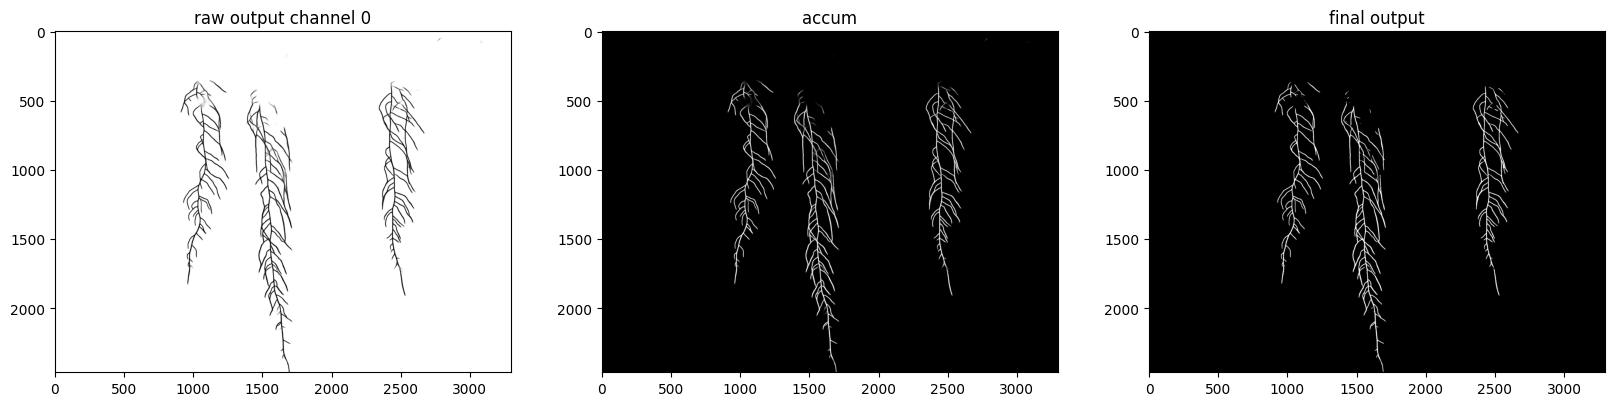

In [ ]:
plt.figure(figsize=(20,8))
plt.subplot(1,3,1)
plt.title("raw output channel 0")
plt.imshow(prediction[0,...,0], cmap="gray")

plt.subplot(1,3,2)
plt.title("accum")
plt.imshow(accum, cmap="gray")

plt.subplot(1,3,3)
plt.title("final output")
plt.imshow(outimg, cmap="gray")

True

In [ ]:
https://github.com/ngaggion/ChronoRoot/blob/master/segmentFast.py

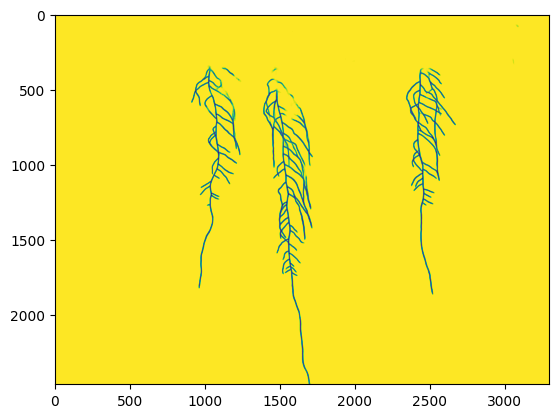

In [ ]:
plt.imshow(prediction[0,...,0])

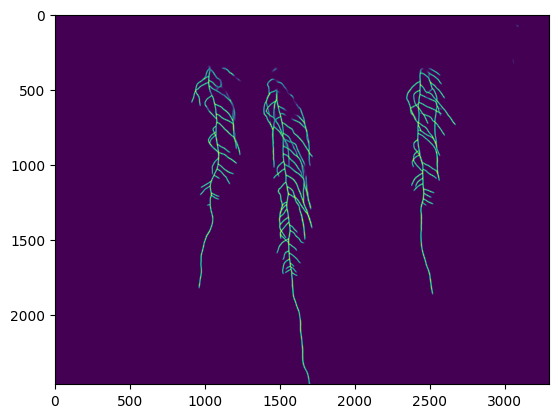

In [ ]:
plt.imshow(prediction[0,...,1])

In [ ]:
# post process with crf


1